### Libraries

In [1]:
# Data manipulation libraries
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Clustering libraries
from kmodes.kmodes import KModes
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, DBSCAN

# Dimensionality reduction libraries
from sklearn.decomposition import PCA

# Evaluation libraries
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics

# Classification libraries
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

### Settings

In [2]:
# Display all rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Notebook random state
random_state = 421

# Set visuals to default
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# Device
folder = 'C:/Users/nuke2/Desktop/NW Work/Data/421/hw02/U.S._Chronic_Disease_Indicators__CDI_.csv' # Desktop
# folder = 'C:/Users/Sam/Desktop/NW Work/DATA/421/hw02/U.S._Chronic_Disease_Indicators__CDI_.csv' # Laptop

# Question 2

#### Generate Data

In [3]:
# Set variables for simulated data
n_features = 15
n_classes = 3
n_informative = 6

# Generate random multidimensional data with 1000 samples and 15 features
X_2, y_2 = make_classification(n_samples=1000, 
                               n_features=n_features,
                               n_classes=n_classes,
                               n_informative=n_informative,
                               random_state=random_state)

### Build a K-means function from scratch (without using sklearn) and make assumptions to simplify the code as needed

In [4]:
# Initialize random centroids
def random_centroids(X, k, random_state=random_state):
    random.seed(random_state)
    num_samples, num_features = X.shape
    centroids = X[np.random.choice(num_samples, k, replace=False), :]
    return centroids

# Find distances for each point
def find_distance(X, k, centroids):
    num_samples, num_features = X.shape
    distances = np.zeros((num_samples, k))
    for cluster in range(k):
            distances[:, cluster] = np.linalg.norm(X - centroids[cluster, :], axis=1)
    return distances

# Assign labels to all points
def assign_labels(distances):
    cluster_assignment = np.argmin(distances, axis=1)
    return cluster_assignment

# Updates centroids for each cluster
def update_centroids(X, labels, k, centroids):
    for cluster in range(k):
            centroids[cluster, :] = np.mean(X[labels == cluster, :], axis=0)
    return centroids

# K-means from scratch function
def kmeans_scratch(data, k, max_iter=100, random_state=random_state):
    random.seed(random_state)
    
    # Init random centroids
    centroids = random_centroids(data, k)
    centroids_old = centroids.copy()
    
    for iteration in range(max_iter):
        # Calculate distances for each point
        distances = find_distance(data, k, centroids)
        # Get labels
        labels = assign_labels(distances)
        # Update centroids
        centroids = update_centroids(data, labels, k, centroids)
        
        if np.array_equal(centroids, centroids_old):
            break
            
        centroids_old = centroids.copy()
    
    return labels, centroids

### Use the elbow method to find an appropriate value for k

In [5]:
def elbow_plot(data):
    # Set the range of k values to try
    k_range = range(1, 11)

    # Initialize an empty list to store the WSS values for each k
    wss_values = []

    # Compute the WSS values for each k
    for k in k_range:
        # Run K-Means clustering with the current value of k
        labels, centroids = kmeans_scratch(data, k)

        # Compute the sum of squared distances of samples to their closest cluster center
        distances = find_distance(data, k, centroids)
        wss = np.sum(np.min(distances, axis=1) ** 2)
        wss_values.append(wss)

    # Plot the WSS values vs. k
    plt.plot(k_range, wss_values, 'o-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Within-cluster Sum of Squares (WSS)')
    plt.title('Elbow method for optimal k')
    plt.show()

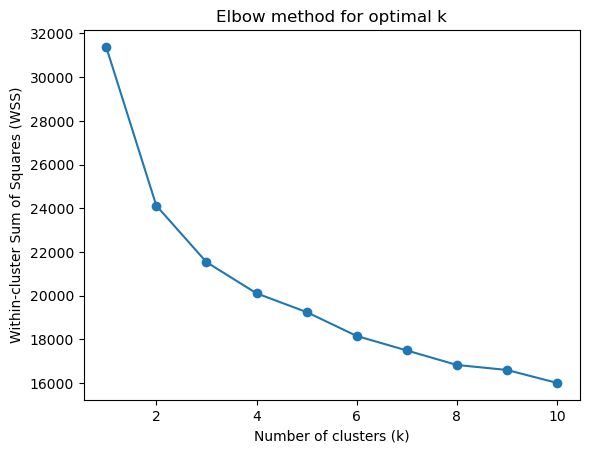

In [6]:
elbow_plot(X_2)

k=3 looks to be a good elbow point

### Use the silhouette plot to evaluate your clusters

In [7]:
def plot_silhouettes(data, labels, k):    
    # Compute the silhouette score for the clustering result
    silhouette_avg = silhouette_score(data, labels)

    # Compute the silhouette values for each sample
    silhouette_values = silhouette_samples(data, labels)

    # Set up the plot
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 4)

    # Set the color map for the plot
    cmap = cm.get_cmap("nipy_spectral")

    # Plot the silhouette values for each sample
    y_lower = 10
    for i in range(k):
        # Check for empty clusters
        if np.sum(labels == i) == 0:
            continue

        # Aggregate the silhouette values for samples in cluster i
        cluster_silhouette_values = silhouette_values[labels == i]
        cluster_silhouette_values.sort()
        cluster_size = cluster_silhouette_values.shape[0]
        y_upper = y_lower + cluster_size

        # Set the color for the current cluster
        color = cmap(float(i) / k)

        # Fill in the silhouette plot for the current cluster
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plot with the cluster number at the middle
        ax.text(-0.05, y_lower + 0.5 * cluster_size, str(i))

        # Compute the new y_lower for the next plot
        y_lower = y_upper + 10

    # Set the plot properties
    ax.set_title(f"Silhouette plot k={k}")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])
    plt.show()

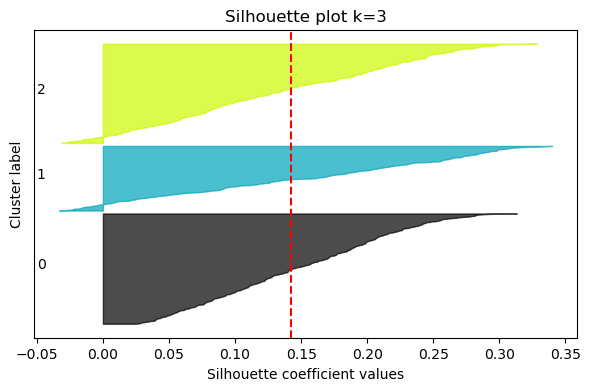

In [8]:
k=3
plot_silhouettes(X_2, kmeans_scratch(X_2, k)[0], k)

The clusters look to be alright. There are not many negative Silhouette coefficient values which indicates we may have found the best clusters. 

### Re-cluster the data to see if you can improve your results

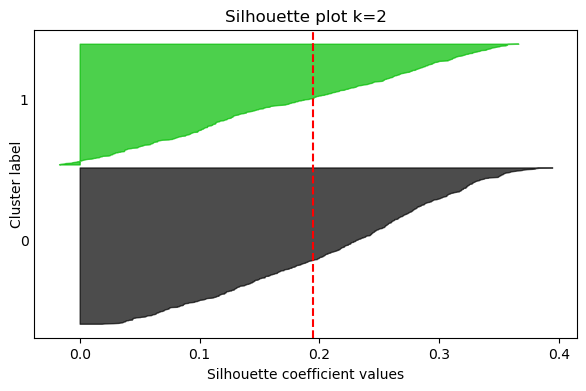

In [9]:
k=2
plot_silhouettes(X_2, kmeans_scratch(X_2, k)[0], k)

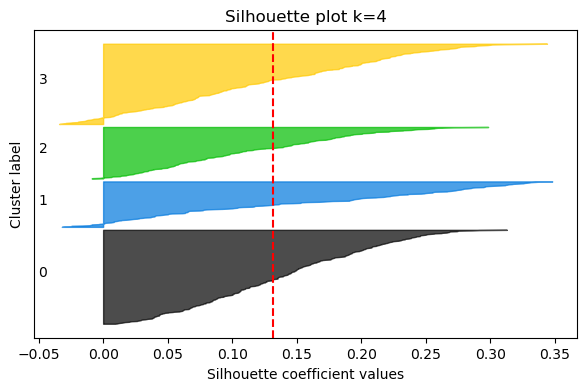

In [10]:
k=4
plot_silhouettes(X_2, kmeans_scratch(X_2, k)[0], k)

As we can see above, there seem to be good results for k=2 and poor results for k=4. k=2 only has a few negative silhouette values while k=4 has many negative silhouette values.

### Perform PCA on the original dataset and retain the most important PCs.

In [11]:
# 3 components seem to explain most of the variance hence n_components=5
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_2)

### Run K-means on the PCA output, compare results with respect to cluster quality and time taken

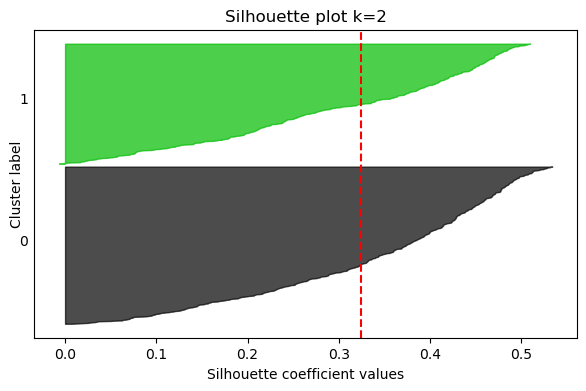

In [12]:
k=2
plot_silhouettes(X_pca, kmeans_scratch(X_pca, k)[0], k)

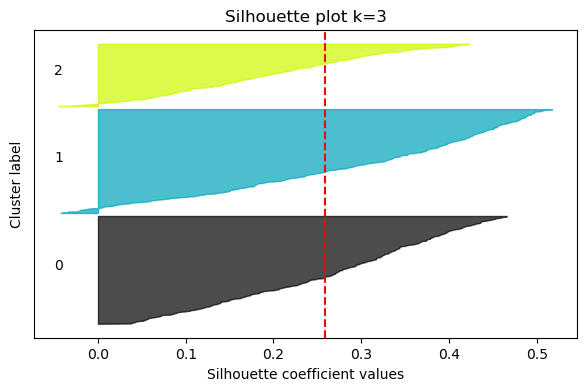

In [13]:
k=3
plot_silhouettes(X_pca, kmeans_scratch(X_pca, k)[0], k)

After looking at the results we can see clustering with two groups performs better when using the three most important principal components, while clustering with three groups performs worse.

# Question 3

In [14]:
# Read data
df_3 = pd.read_csv(folder, low_memory=False)
df_3.head()

YearStart  YearEnd LocationAbbr          LocationDesc DataSource   Topic  \
0       2014     2014           AR              Arkansas  SEDD; SID  Asthma   
1       2018     2018           CO              Colorado  SEDD; SID  Asthma   
2       2018     2018           DC  District of Columbia  SEDD; SID  Asthma   
3       2017     2017           GA               Georgia  SEDD; SID  Asthma   
4       2010     2010           MI              Michigan  SEDD; SID  Asthma   

                      Question  Response DataValueUnit DataValueType  \
0  Hospitalizations for asthma       NaN           NaN        Number   
1  Hospitalizations for asthma       NaN           NaN        Number   
2  Hospitalizations for asthma       NaN           NaN        Number   
3  Hospitalizations for asthma       NaN           NaN        Number   
4  Hospitalizations for asthma       NaN           NaN        Number   

  DataValue  DataValueAlt DataValueFootnoteSymbol DatavalueFootnote  \
0       916         916.0                     NaN               NaN   
1      2227        2227.0                     NaN               NaN   
2       708         708.0                     NaN               NaN   
3      3520        3520.0                     NaN               NaN   
4       123         123.0                     NaN               NaN   

   LowConfidenceLimit  HighConfidenceLimit StratificationCategory1  \
0                 NaN                  NaN                  Gender   
1                 NaN                  NaN                 Overall   
2                 NaN                  NaN                 Overall   
3                 NaN                  NaN                  Gender   
4                 NaN                  NaN          Race/Ethnicity   

  Stratification1  StratificationCategory2  Stratification2  \
0            Male                      NaN              NaN   
1         Overall                      NaN              NaN   
2         Overall                      NaN              NaN   
3          Female                      NaN              NaN   
4        Hispanic                      NaN              NaN   

   StratificationCategory3  Stratification3  \
0                      NaN              NaN   
1                      NaN              NaN   
2                      NaN              NaN   
3                      NaN              NaN   
4                      NaN              NaN   

                                      GeoLocation  ResponseID  LocationID  \
0    POINT (-92.27449074299966 34.74865012400045)         NaN           5   
1  POINT (-106.13361092099967 38.843840757000464)         NaN           8   
2                    POINT (-77.036871 38.907192)         NaN          11   
3    POINT (-83.62758034599966 32.83968109300048)         NaN          13   
4     POINT (-84.71439026999968 44.6613195430005)         NaN          26   

  TopicID QuestionID DataValueTypeID StratificationCategoryID1  \
0     AST     AST3_1            NMBR                    GENDER   
1     AST     AST3_1            NMBR                   OVERALL   
2     AST     AST3_1            NMBR                   OVERALL   
3     AST     AST3_1            NMBR                    GENDER   
4     AST     AST3_1            NMBR                      RACE   

  StratificationID1  StratificationCategoryID2  StratificationID2  \
0              GENM                        NaN                NaN   
1               OVR                        NaN                NaN   
2               OVR                        NaN                NaN   
3              GENF                        NaN                NaN   
4               HIS                        NaN                NaN   

   StratificationCategoryID3  StratificationID3  
0                        NaN                NaN  
1                        NaN                NaN  
2                        NaN                NaN  
3                        NaN                NaN  
4                        NaN                NaN

### Data Transformation

In [15]:
# Retain a limited subset of the data for the year 2020
df_3_filtered = df_3[(df_3.YearStart == 2020)]

# Set questions
q_1 = 'Mortality from heart failure'
q_2 = 'Mortality from total cardiovascular diseases'
q_3 = 'Mortality from diseases of the heart'
q_4 = 'Mortality from coronary heart disease'

# Retain a limited subset of Questions
df_3_filtered = df_3_filtered[(df_3_filtered.Question.isin([
    q_1, q_2, q_3, q_4
]))]

# Filter stratification
df_3_filtered_gender = df_3_filtered.copy()
df_3_filtered_gender = df_3_filtered_gender[df_3_filtered_gender.StratificationCategory1=='Gender']

# Create clustering dataframe for gender
df_3_filtered_gender = df_3_filtered_gender.groupby(['Question', 
                                                     'LocationAbbr', 
                                                     'Stratification1']).agg('mean', numeric_only=True)
df_3_filtered_gender = df_3_filtered_gender[['DataValueAlt']]

# Retrieve data for each question and create separate dataframes
heart_failure = df_3_filtered_gender.loc[q_1].reset_index().copy()
total_cardiovascular_diseases = df_3_filtered_gender.loc[q_2].reset_index().copy()
diseases_of_the_heart = df_3_filtered_gender.loc[q_3].reset_index().copy()
coronary_heart_disease = df_3_filtered_gender.loc[q_4].reset_index().copy()

# Rename column for heart_failure dataframe
heart_failure = heart_failure.rename(columns={'DataValueAlt': 'heart_failure'})

# Create a new dataframe with cleaned data
cleaned_data = heart_failure.copy()
cleaned_data['total_cardiovascular_diseases'] = total_cardiovascular_diseases['DataValueAlt']
cleaned_data['diseases_of_the_heart'] = diseases_of_the_heart['DataValueAlt']
cleaned_data['coronary_heart_disease'] = coronary_heart_disease['DataValueAlt']

# Preview the cleaned_data dataframe
cleaned_data.head()

LocationAbbr Stratification1  heart_failure  total_cardiovascular_diseases  \
0           AK          Female     131.866667                     262.666667   
1           AK            Male     155.633333                     390.300000   
2           AL          Female    1297.700000                    3307.266667   
3           AL            Male    1276.800000                    3643.966667   
4           AR          Female     924.233333                    1934.433333   

   diseases_of_the_heart  coronary_heart_disease  
0             182.933333               81.933333  
1             298.900000              183.333333  
2            2414.400000              780.133333  
3            2861.333333             1131.600000  
4            1446.166667              763.700000

### Exploratory Data Analysis

In [16]:
# Show descriptive statistics
for question in ['heart_failure', 'total_cardiovascular_diseases', 'diseases_of_the_heart', 'coronary_heart_disease']:
    print(cleaned_data[question].describe())

count     102.000000
mean     1440.632026
std      1323.853324
min       131.866667
25%       445.941667
50%      1148.033333
75%      1727.875000
max      7169.733333
Name: heart_failure, dtype: float64
count      102.000000
mean      3206.275817
std       3233.032136
min        262.666667
25%        932.741667
50%       2266.116667
75%       3778.533333
max      16745.166667
Name: total_cardiovascular_diseases, dtype: float64
count      102.000000
mean      2407.290850
std       2407.828103
min        182.933333
25%        701.450000
50%       1766.050000
75%       2932.008333
max      12594.633333
Name: diseases_of_the_heart, dtype: float64
count     102.000000
mean     1321.183333
std      1480.757697
min        81.933333
25%       411.075000
50%       835.333333
75%      1537.858333
max      7996.266667
Name: coronary_heart_disease, dtype: float64


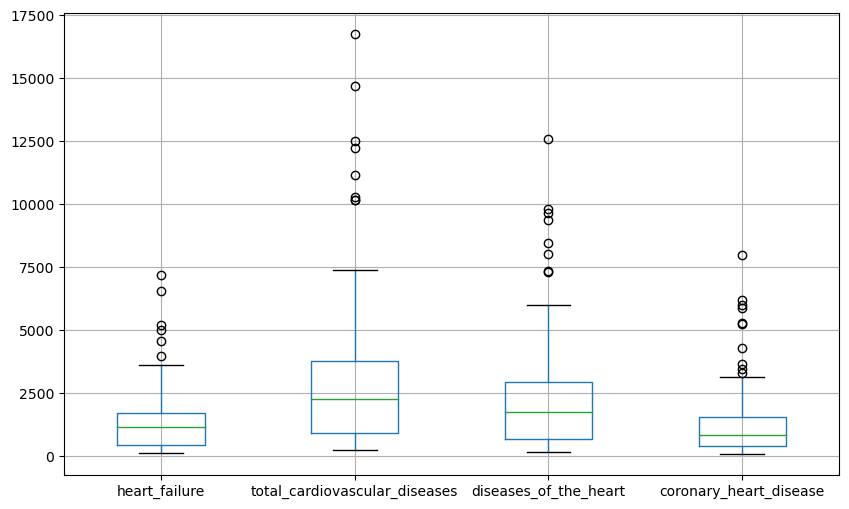

In [17]:
# Create boxplot
fig, ax = plt.subplots(figsize=(10, 6))
cleaned_data.boxplot(ax=ax)
plt.show()

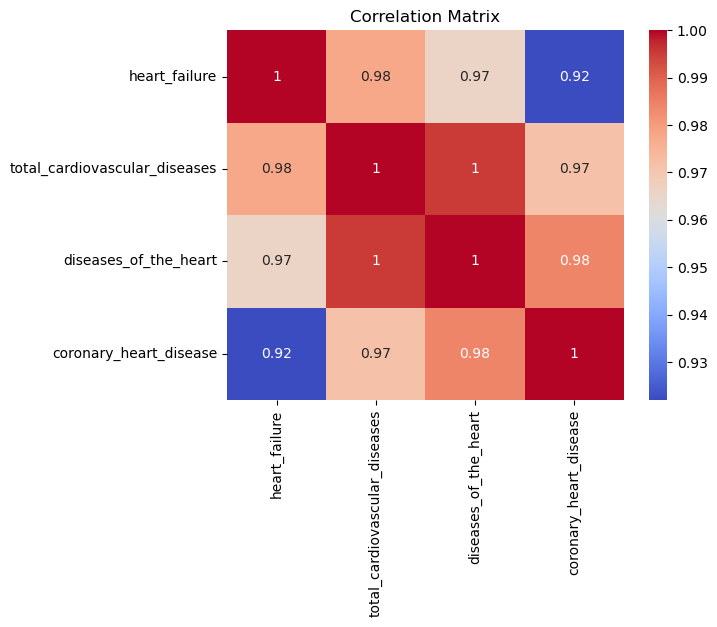

In [18]:
# Create a correlation matrix
corr_matrix = cleaned_data.corr()

# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

plt.title('Correlation Matrix')
plt.show()

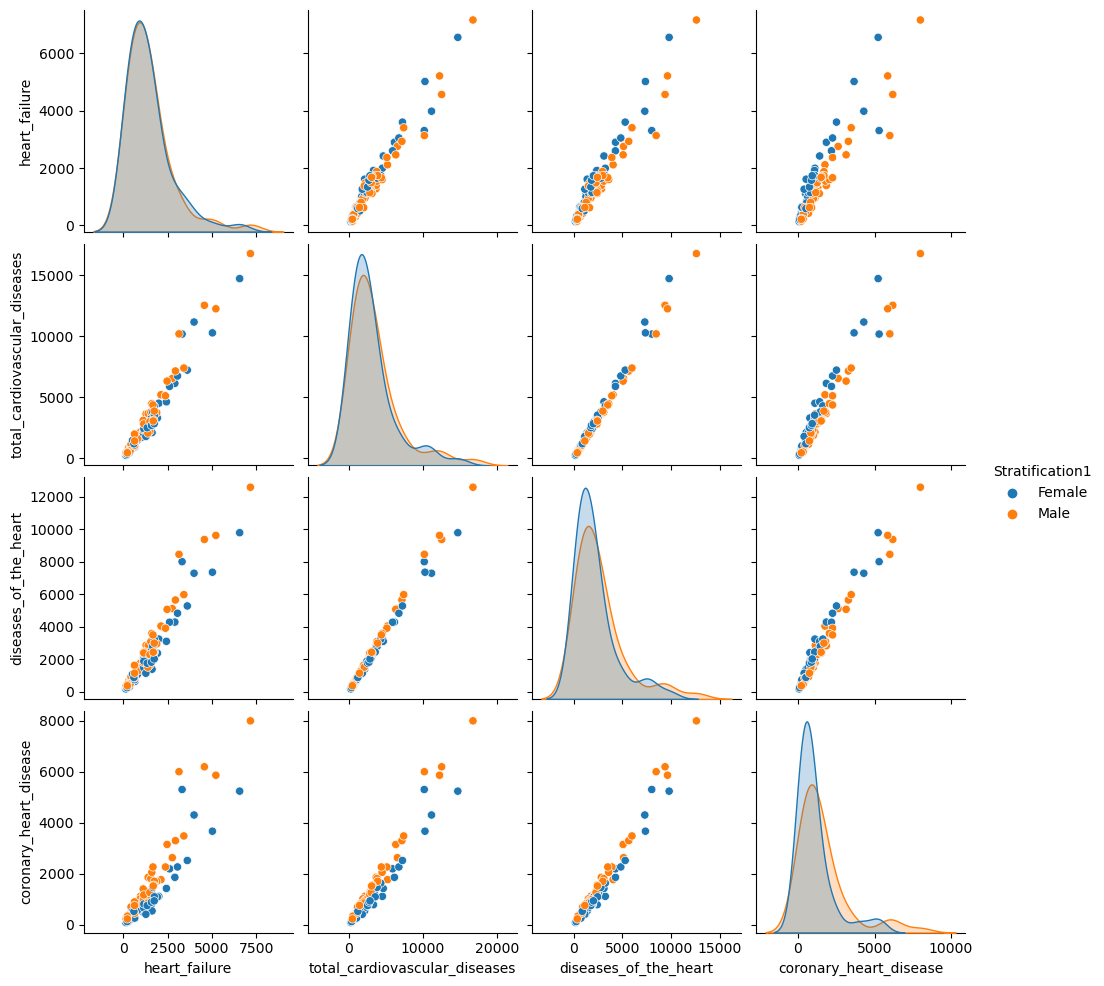

In [19]:
sns.pairplot(cleaned_data, hue='Stratification1')
plt.show()

### Clustering

Using these four questions:
- Mortality from heart failure
- Mortality from total cardiovascular diseases
- Mortality from diseases of the heart
- Mortality from coronary heart disease

We can perform cluster analysis to find groups of people that are highly likely to have these problems.

In [20]:
# Scale data
scaler = StandardScaler()
cleaned_data.iloc[:, 2:] = scaler.fit_transform(cleaned_data.iloc[:, 2:])

# Get first two PCs
pca = PCA(n_components=2)
principal_components = pca.fit_transform(cleaned_data.iloc[:, 2:])
df_pca = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])

#### List the various clustering algorithm(s) youâ€™d use and why
- KMeans: KMeans is a good choice here as it is a popular clustering algorithm and good benchmark for our other clustering methods.
- Hierarchical Clustering: Hierarchical Clustering is a good choice here because we can identify sub-clusters which may be present in our data. It can also help us understand relative distances between clusters.
- DBSCAN: DBSCAN is good here because it will allow us to automatically determine clusters within the data. We can then compare this to the other methods to validatie performance.

#### KMeans

C:\Users\nuke2\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


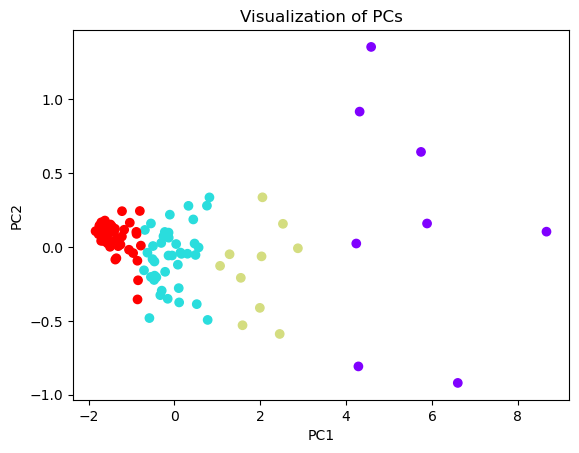

In [21]:
# Set the number of clusters to 4
n_clusters = 4

# Create a KMeans object with 4 clusters and a random state
kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)

# Fit the cleaned data to the KMeans object
kmeans.fit(cleaned_data.iloc[:, 2:])

# Get the labels for the clusters
labels = kmeans.labels_

# Customize colors
n_labels = len(set(labels))
label_colors = cm.rainbow(np.linspace(0, 1, n_labels))
cmap = ListedColormap(label_colors)

# Create a scatter plot of the first two principal components, colored by cluster label
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=labels, cmap=cmap)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Visualization of PCs')
plt.show()

#### Hierarchical Clustering

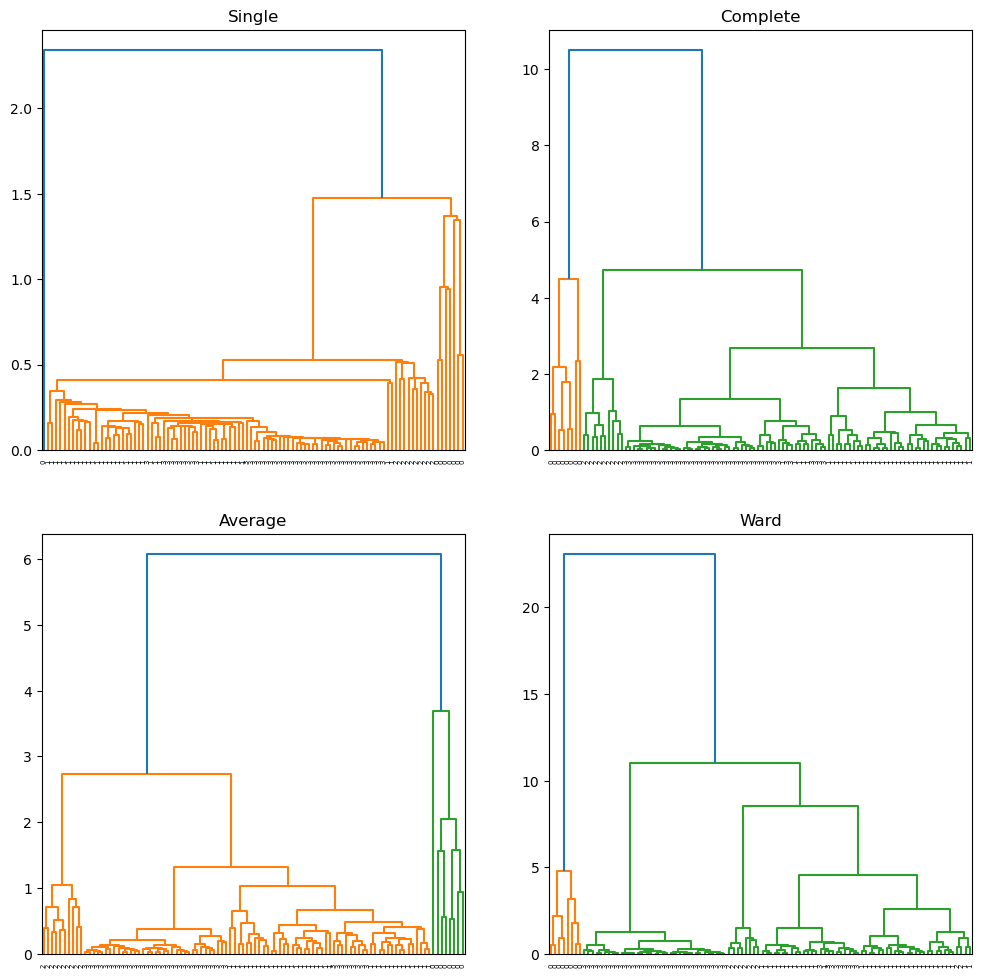

In [22]:
# convert data format for hierachical clustering
dat_c = cleaned_data.iloc[:, 2:].to_numpy()

# construct the linkage
Z1 = linkage(dat_c, method='single', metric='euclidean')
Z2 = linkage(dat_c, method='complete', metric='euclidean')
Z3 = linkage(dat_c, method='average', metric='euclidean')
Z4 = linkage(dat_c, method='ward', metric='euclidean')

# show the plot
plt.figure(figsize=(12, 12))
plt.subplot(2,2,1), dendrogram(Z1,labels=labels), plt.title('Single')
plt.subplot(2,2,2), dendrogram(Z2,labels=labels), plt.title('Complete')
plt.subplot(2,2,3), dendrogram(Z3,labels=labels), plt.title('Average')
plt.subplot(2,2,4), dendrogram(Z4,labels=labels), plt.title('Ward')
plt.show()

#### DBSCAN

Number of clusters: 1
Silhouette score: 0.6810601912315879


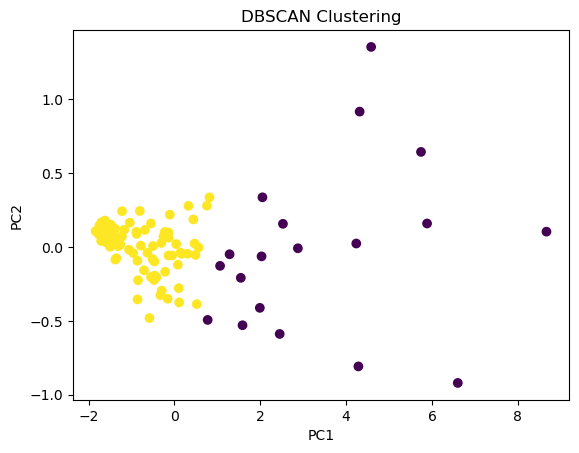

In [23]:
# compute DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan.fit(cleaned_data.iloc[:, 2:])

# print the number of clusters (-1 indicates outliers)
n_clusters_ = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
print('Number of clusters:', n_clusters_)

# print the silhouette score (a higher score indicates better clustering)
silhouette_score = metrics.silhouette_score(cleaned_data.iloc[:, 2:], dbscan.labels_)
print('Silhouette score:', silhouette_score)

# plot the clusters
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=dbscan.labels_)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('DBSCAN Clustering')
plt.show()

#### Report on the quality of the clusters, pros/cons, and summarize your findings

Quality:
- KMeans: The quality of the clusters is good. It looks as if there are levels to the data which KMeans captures. 
- Hierarchical Clustering: We can see a result similar to what KMeans tells us here, that there are levels to the data. As you go further toward the dense cluster, you go deeper into the levels.
- DBSCAN: DBSCAN has selected two levels but I think there is more to it. The quality of the clusters seem to be good however I think it is missing the different levels the other two algorithms captured.

Pros/Cons:
- KMeans: KMeans lets us control the number of clusters which is both good and bad. We can make it too granular if we want which will result in poor cluster quality.
- Hierarchical Clustering: Hierarchical Clustering lets us easily visualize the data in a very easy to read way. The main con is that it is sensative to outliers which is hard to tell for this specific dataset. 
- DBSCAN: One pro of DBSCAN is that it can help guide us to the correct number of clusters. We don't know in this case how many should be in the two clusters it has chosen, which is the con here.

Summary:

All in all, I think KMeans and Hierarchical Clustering show that there are levels to this data. We can see in both that as you get more granular, levels start to appear. For this reason DBSCAN was not a successful candidate and we should go with what the first two algorithms show us.

### Bias/Fairness Questions 

### Data

#### Checking cluster averages

In [24]:
cleaned_data['labels'] = labels
cleaned_data.head()

LocationAbbr Stratification1  heart_failure  total_cardiovascular_diseases  \
0           AK          Female      -0.993485                      -0.914976   
1           AK            Male      -0.975444                      -0.875303   
2           AL          Female      -0.108500                       0.031391   
3           AL            Male      -0.124365                       0.136049   
4           AR          Female      -0.391999                      -0.395333   

   diseases_of_the_heart  coronary_heart_disease  labels  
0              -0.928364               -0.841035       3  
1              -0.879964               -0.772219       3  
2               0.002967               -0.367192       1  
3               0.189501               -0.128664       1  
4              -0.401138               -0.378344       3

In [25]:
data_bias = cleaned_data.groupby(['labels', 'Stratification1']).agg({'Stratification1': 'count',
                                                                     'heart_failure': 'mean',
                                                                     'total_cardiovascular_diseases': 'mean',
                                                                     'diseases_of_the_heart': 'mean',
                                                                     'coronary_heart_disease': 'mean'}).copy()
data_bias = data_bias.rename(columns={'Stratification1': 'gender_counts'}).reset_index()
data_bias_std = cleaned_data.groupby(['labels', 'Stratification1']).agg({'heart_failure': 'std',
                                                                         'total_cardiovascular_diseases': 'std',
                                                                         'diseases_of_the_heart': 'std',
                                                                         'coronary_heart_disease': 'std'}).copy()
data_bias_std = data_bias_std.reset_index().rename(columns={
    'heart_failure': 'heart_failure_std',
    'total_cardiovascular_diseases': 'total_cardiovascular_diseases_std',
    'diseases_of_the_heart': 'diseases_of_the_heart_std',
    'coronary_heart_disease': 'coronary_heart_disease_std'
})
data_bias = pd.concat([data_bias, data_bias_std.iloc[:, 2:]], axis=1)
data_bias

labels Stratification1  gender_counts  heart_failure  \
0       0          Female              4       2.489466   
1       0            Male              4       2.719543   
2       1          Female             19       0.077168   
3       1            Male             21      -0.038681   
4       2          Female              4       1.214259   
5       2            Male              6       0.936850   
6       3          Female             24      -0.693390   
7       3            Male             20      -0.766335   

   total_cardiovascular_diseases  diseases_of_the_heart  \
0                       2.600414               2.383317   
1                       3.019717               3.175854   
2                      -0.030694              -0.074292   
3                      -0.047770               0.001512   
4                       1.023508               0.947087   
5                       0.958202               1.068444   
6                      -0.692588              -0.715150   
7                      -0.705765              -0.694615   

   coronary_heart_disease  heart_failure_std  \
0                2.243135           1.075075   
1                3.523589           1.271241   
2               -0.218299           0.262365   
3                0.036456           0.203895   
4                0.600177           0.318852   
5                0.977526           0.349898   
6               -0.672594           0.238716   
7               -0.590420           0.148677   

   total_cardiovascular_diseases_std  diseases_of_the_heart_std  \
0                           0.663057                   0.485850   
1                           0.856007                   0.747169   
2                           0.240490                   0.232343   
3                           0.237712                   0.260777   
4                           0.186653                   0.201501   
5                           0.296656                   0.348462   
6                           0.165927                   0.158868   
7                           0.139765                   0.152908   

   coronary_heart_disease_std  
0                    0.534198  
1                    0.677318  
2                    0.196009  
3                    0.269966  
4                    0.185006  
5                    0.451174  
6                    0.127259  
7                    0.145010

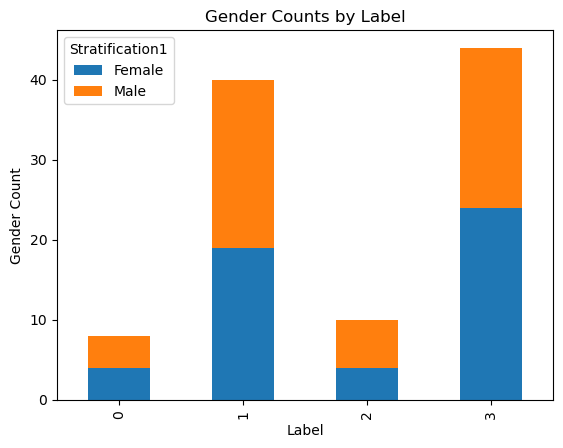

In [26]:
# Pivot the data to create a multi-level column index for the stacked bars
stacked = data_bias.iloc[:, :3].pivot(index='labels', columns='Stratification1', values='gender_counts')

# Create a stacked bar chart
stacked.plot(kind='bar', stacked=True)

# Add the chart title and axis labels
plt.title('Gender Counts by Label')
plt.xlabel('Label')
plt.ylabel('Gender Count')

# Show the chart
plt.show()

As we can see above, the stacked bar chart indicated that the genders are pretty even by cluster. This suggests that the other differentiator, location, plays a bigger part in the clustering. Look at the visualization of mean by state below:

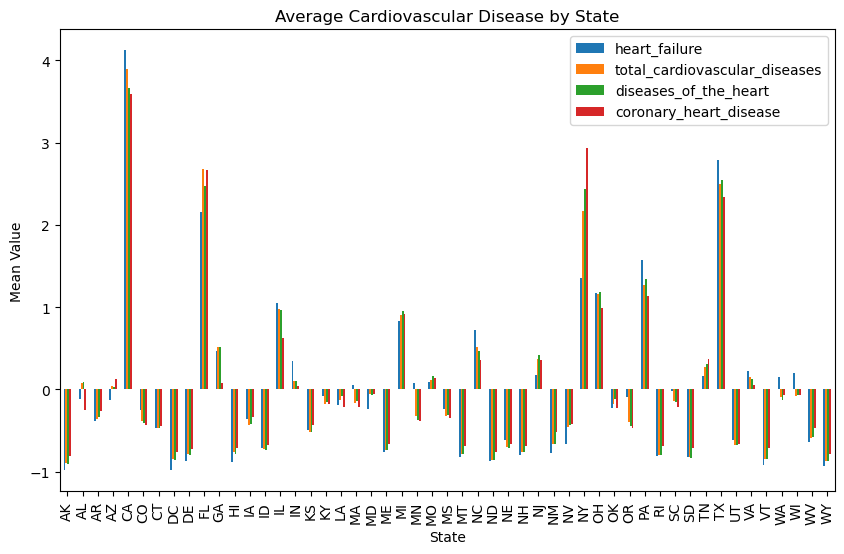

In [27]:
# calculate the average of the four columns grouped by state
state_means = cleaned_data.groupby('LocationAbbr')[['heart_failure', 
                                                    'total_cardiovascular_diseases',
                                                    'diseases_of_the_heart',
                                                    'coronary_heart_disease']].mean()

# plot the bar chart
state_means.plot(kind='bar', figsize=(10, 6))

# add chart title and axis labels
plt.title('Average Cardiovascular Disease by State')
plt.xlabel('State')
plt.ylabel('Mean Value')

# show the chart
plt.show()

We can see that the values vary widely by state. However, within state we can see that the values are pretty close for all columns. From this figure along with the previous figure regarding gender and counts, we can conclude that gender has a much less significance than location when it comes to rates of heart illness.

#### Do you detect bias in the data?
- I do not see much bias relative to the difference by state.

#### Based on the EDA and your project objective, develop a hypothesis about where b/f issues could arise in the modeling (cluster analysis).
- B/F issues could arise if the numbers varied less by state and more by gender. If we try to model using gender + location we could potentially run into issues. Again, this could be more prevalent if we control for state; only selecting states within a certain range of values.

### Modeling

#### Explain the reasoning for the groups that you selected for the fairness metrics
- I chose male and female because the goal is to minimize bais and fairness between the groups

In [28]:
# Label encode the categorical variables
lbl = preprocessing.LabelEncoder()
cleaned_data['LocationAbbr'] = lbl.fit_transform(cleaned_data['LocationAbbr'].astype(str))
cleaned_data['Stratification1'] = lbl.fit_transform(cleaned_data['Stratification1'].astype(str))

# Get features and labels
X = cleaned_data.drop('labels', axis=1)
y = cleaned_data['labels']

In [29]:
# Define the parameter grid for the grid search
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 150]
}

# Create an instance of the XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=4, 
                            seed=random_state,
                            verbosity = 0)

# Create a GridSearchCV object with the parameter grid and XGBoost classifier
grid_search = GridSearchCV(estimator=xgb_clf, 
                           param_grid=param_grid, 
                           cv=3, 
                           scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X, y)

# Print the best parameters and best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Use the best parameters to create the XGBoost classifier and fit it to all data
best_xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                                 verbosity = 0, 
                                 num_class=4, 
                                 seed=random_state, 
                                 **grid_search.best_params_)
best_xgb_clf.fit(X, y)
print(f"[INFO] -- Fit best model")

Best parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best score:  0.9215686274509803
[INFO] -- Fit best model


#### Process the test data for modeling

In [30]:
# Retain a limited subset of the data for predictions
df_modeling_test = df_3[(df_3.YearStart == 2019) & (df_3.YearEnd == 2019)]

# Retain a limited subset of Questions
df_modeling_test_filtered = df_modeling_test[(df_modeling_test.Question.isin([
    q_1, q_2, q_3, q_4
]))]

# Filter stratification
df_modeling_test_filtered_gender = df_modeling_test_filtered.copy()
df_modeling_test_filtered_gender = df_modeling_test_filtered_gender[df_modeling_test_filtered_gender.StratificationCategory1=='Gender']

# Create clustering dataframe for gender
df_modeling_test_filtered_gender = df_modeling_test_filtered_gender.groupby(['Question', 
                                                                             'LocationAbbr', 
                                                                             'Stratification1']).agg('mean', numeric_only=True)
df_modeling_test_filtered_gender = df_modeling_test_filtered_gender[['DataValueAlt']]

# Retrieve data for each question and create separate dataframes
heart_failure_modeling = df_modeling_test_filtered_gender.loc[q_1].reset_index().copy()
total_cardiovascular_diseases_modeling = df_modeling_test_filtered_gender.loc[q_2].reset_index().copy()
diseases_of_the_heart_modeling = df_modeling_test_filtered_gender.loc[q_3].reset_index().copy()
coronary_heart_disease_modeling = df_modeling_test_filtered_gender.loc[q_4].reset_index().copy()

# Rename column for heart_failure dataframe
heart_failure_modeling = heart_failure_modeling.rename(columns={'DataValueAlt': 'heart_failure'})

# Create a new dataframe with cleaned data
cleaned_data_modeling = heart_failure.copy()
cleaned_data_modeling['total_cardiovascular_diseases'] = total_cardiovascular_diseases_modeling['DataValueAlt']
cleaned_data_modeling['diseases_of_the_heart'] = diseases_of_the_heart_modeling['DataValueAlt']
cleaned_data_modeling['coronary_heart_disease'] = coronary_heart_disease_modeling['DataValueAlt']

# Change datatype for model fitting
cleaned_data_modeling['LocationAbbr'] = lbl.fit_transform(cleaned_data_modeling['LocationAbbr'].astype(str))
cleaned_data_modeling['Stratification1'] = lbl.fit_transform(cleaned_data_modeling['Stratification1'].astype(str))

# Get labels or "ground truth"
kmeans.fit(cleaned_data_modeling.iloc[:, 2:])
labels = kmeans.labels_
cleaned_data_modeling['labels'] = labels

# Get X and y test
X_test = cleaned_data_modeling.drop('labels', axis=1)
y_test = cleaned_data_modeling['labels']

C:\Users\nuke2\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


#### Testing model

In [31]:
y_pred = best_xgb_clf.predict(X_test)
print(f"Test accuracy: {round(np.mean(y_pred==y_test), 4) * 100}%")

Test accuracy: 37.25%


As we can see the test accuracy is not very high. However, that is not what we are concerned about, we are concerned about the bias and fairness of this model. Using gender we can evaluate if that played a role in this prediction using the fairlearn package

In [32]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score

### Compare the fairness metrics for the different groups.

In [33]:
gm = MetricFrame(metrics=accuracy_score, 
                 y_true=y_test, 
                 y_pred=y_pred, 
                 sensitive_features=cleaned_data_modeling['Stratification1'])
print(f"Overall accuracy: {round(gm.overall, 4) * 100}%")
print(f"===")
print(f"Fairness evaluation:")
print(f" - Female accuracy: {round(gm.by_group[0], 4) * 100}%")
print(f" - Male accuracy: {round(gm.by_group[1], 4) * 100}%")

Overall accuracy: 37.25%
===
Fairness evaluation:
 - Female accuracy: 35.29%
 - Male accuracy: 39.22%


### Comment on the results
As we can see above, we get a large difference in accuracy when we use gender as a variable, almost 5%! We are able to predict males' labels much better than females using the gender feature.

To mitigate this issue, we should exclude gender from our training set. This may result in lower prediction accuracy but at the cost of being unfair to certain groups of people. Below is a bar chart where we can see the difference in accuracy more easily:

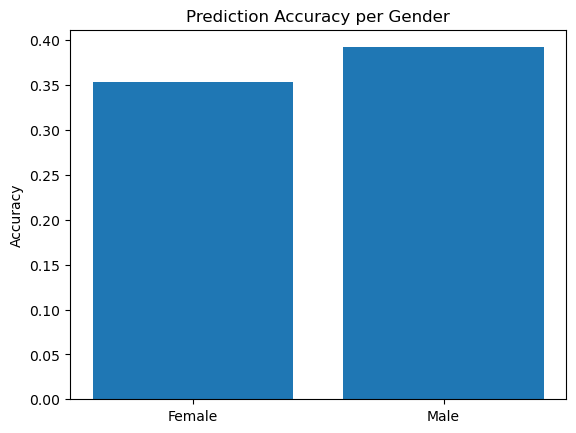

In [34]:
# Create bar chart
plt.bar(['Female', 'Male'], [gm.by_group[0], gm.by_group[1]])

# Add labels and title
plt.ylabel('Accuracy')
plt.title('Prediction Accuracy per Gender')

# Show the chart
plt.show()